Fetching malicious URLs from OpenPhish...
Final dataset size: 1090518
label
1    744780
0    345738
Name: count, dtype: int64


c:\Users\aktiw\OneDrive\Desktop\Milicious Url Prediction Model\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:25:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



====== Random Forest ======
Accuracy: 0.9910363863111177
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     69148
           1       1.00      0.99      0.99    148956

    accuracy                           0.99    218104
   macro avg       0.99      0.99      0.99    218104
weighted avg       0.99      0.99      0.99    218104



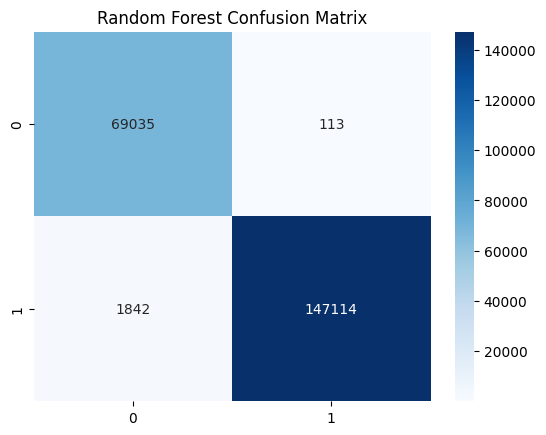


====== XGBoost ======
Accuracy: 0.9919212852584088
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     69148
           1       1.00      0.99      0.99    148956

    accuracy                           0.99    218104
   macro avg       0.99      0.99      0.99    218104
weighted avg       0.99      0.99      0.99    218104



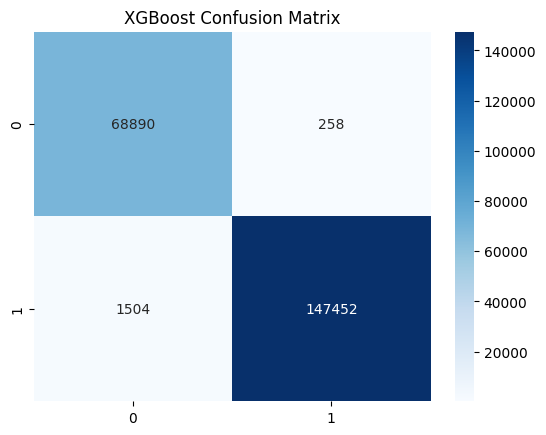


====== Logistic Regression ======
Accuracy: 0.9821369621831787
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     69148
           1       1.00      0.98      0.99    148956

    accuracy                           0.98    218104
   macro avg       0.97      0.99      0.98    218104
weighted avg       0.98      0.98      0.98    218104



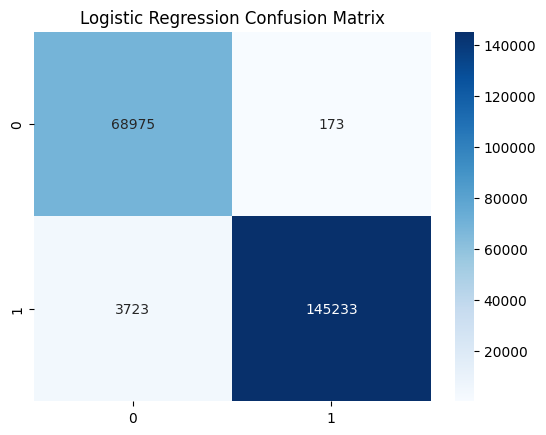

C:\Users\aktiw\AppData\Local\Temp\ipykernel_19680\1025121850.py:146: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_benign = X[y == 0]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [11]:
# ===========================
# 1. Install Libraries
# ===========================
# pip install pandas numpy scikit-learn xgboost requests seaborn matplotlib

# ===========================
# 2. Import Libraries
# ===========================
import pandas as pd
import numpy as np
import requests
import re
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# ===========================
# 3. Fetch OpenPhish URLs
# ===========================
print("Fetching malicious URLs from OpenPhish...")
openphish_url = "https://openphish.com/feed.txt"
response = requests.get(openphish_url)
malicious_urls = response.text.splitlines()
openphish_df = pd.DataFrame({"url": malicious_urls})
openphish_df["label"] = 1

# ===========================
# 4. Load Kaggle Datasets
# ===========================
# urldata.csv columns: ,url,label,result
urldata = pd.read_csv("urldata.csv")
urldata = urldata[["url", "label"]]

# Convert string labels to int
urldata['label'] = urldata['label'].map({'benign':0, 'malicious':1}).astype(int)

# malicious_phish.csv columns: url,type
malicious_phish = pd.read_csv("malicious_phish.csv")
malicious_phish["label"] = 1  # all malicious
malicious_phish = malicious_phish[["url", "label"]]

# Combine Kaggle + OpenPhish
df = pd.concat([urldata, malicious_phish, openphish_df], ignore_index=True)

# ===========================
# 5. Clean Dataset
# ===========================
df = df[df['url'].notna()]                        # remove NaN
df = df[df['url'].str.strip() != ""]             # remove empty
df['url'] = df['url'].str.strip()
df = df[df['url'].str.len() < 2048]              # remove very long URLs
df.drop_duplicates(subset="url", inplace=True)
df['label'] = df['label'].astype(int)            # ensure numeric

print("Final dataset size:", len(df))
print(df['label'].value_counts())

# ===========================
# 6. Feature Engineering
# ===========================
suspicious_words = ["login","verify","update","free","secure","account","bank"]

def extract_features(url):
    try:
        parsed = urlparse(url)
        domain = parsed.netloc if parsed.netloc else parsed.path
        return {
            "url_length": int(len(url)),
            "num_dots": int(url.count('.')),
            "num_digits": int(sum(c.isdigit() for c in url)),
            "num_hyphens": int(url.count('-')),
            "num_params": int(url.count('=')),
            "has_https": int(url.startswith("https")),
            "has_at": int("@" in url),
            "has_ip": int(bool(re.search(r'\d+\.\d+\.\d+\.\d+', url))),
            "contains_suspicious_words": int(any(word in url.lower() for word in suspicious_words)),
            "tld_len": int(len(domain.split('.')[-1]) if "." in domain else 0)
        }
    except:
        return {
            "url_length": 0,
            "num_dots": 0,
            "num_digits": 0,
            "num_hyphens": 0,
            "num_params": 0,
            "has_https": 0,
            "has_at": 0,
            "has_ip": 0,
            "contains_suspicious_words": 0,
            "tld_len": 0
        }

# Apply feature extraction
X = pd.DataFrame([extract_features(u) for u in df["url"]])

# Ensure numeric features
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
y = df["label"].astype(int)

# ===========================
# 7. Train/Test Split
# ===========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ===========================
# 8. Train Supervised Models
# ===========================
rf_model = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42)
rf_model.fit(X_train, y_train)

xgb_model = XGBClassifier(n_estimators=300, max_depth=7, learning_rate=0.1,
                          use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train, y_train)

# ===========================
# 9. Evaluate Models
# ===========================
def evaluate(model, name):
    print("\n======", name, "======")
    pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, pred))
    print(classification_report(y_test, pred))
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(name + " Confusion Matrix")
    plt.show()

evaluate(rf_model, "Random Forest")
evaluate(xgb_model, "XGBoost")
evaluate(lr_model, "Logistic Regression")

# ===========================
# 10. Optional Unsupervised Model
# ===========================
X_benign = X[y == 0]
iso = IsolationForest(contamination=0.05, random_state=42)
iso.fit(X_benign)

# ===========================
# 11. Save Models
# ===========================
pickle.dump(rf_model, open("rf_model.pkl", "wb"))
pickle.dump(xgb_model, open("xgb_model.pkl", "wb"))
pickle.dump(lr_model, open("lr_model.pkl", "wb"))
pickle.dump(X.columns.tolist(), open("features.pkl", "wb"))

# ===========================
# 12. Standalone Predictor
# ===========================
def predict_url(url):
    model = pickle.load(open("rf_model.pkl", "rb"))  # or xgb_model.pkl
    features = extract_features(url)
    df_input = pd.DataFrame([features])
    df_input = df_input.apply(pd.to_numeric, errors='coerce').fillna(0)
    pred = model.predict(df_input)[0]
    return "MALICIOUS" if pred == 1 else "BENIGN"

# Example usage
url = input("Enter URL to check: ")
print("Result:", predict_url(url))
